#Scrape each book reviews

In [ ]:
# Install dependencies as needed:
!pip install kagglehub
!pip install beautifulsoup4
!pip install requests
!pip install arabic_reshaper
!pip install python-bidi
!pip install wordcloud
!pip install transformers


In [1]:

import kagglehub
from kagglehub import KaggleDatasetAdapter
from bs4 import BeautifulSoup

import requests
import time
import pandas as pd

import matplotlib.pyplot as plt

from collections import Counter
import re
# Use a pipeline as a high-level helper
from transformers import pipeline
import seaborn as sns

import matplotlib.pyplot as plt
from collections import Counter
import arabic_reshaper
from bidi.algorithm import get_display
from wordcloud import WordCloud, ImageColorGenerator

<ipython-input-1-46b5ab085819>:12: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


ValueError: Unsupported file extension: ''. Supported file extensions are: .csv, .tsv, .json, .jsonl, .xml, .parquet, .feather, .sqlite, .sqlite3, .db, .db3, .s3db, .dl3, .xls, .xlsx, .xlsm, .xlsb, .odf, .ods, .odt

In [5]:
# Set the path to the file you'd like to load
file_path = "Abjad_books.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "sajanakhleh/abjad-books-reviews",
  file_path,
)

print("First 5 records:")
df.head()

<ipython-input-5-c0c395216c3b>:5: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:


,BookBadge_Title,Author,Rating,Description,Raters,Reviews,Readers,Link
0,ماجدولين,مصطفى لطفي المنفلوطي,4.4,لا نعرف عن الحُب غير وجهه الأليف الذي نُحِب، ل...,4057,4313,23055,https://www.abjjad.com/book/15445318/%D9%85%D8...
1,هكذا خُلقت,محمد حسين هيكل,4.2,روايةٌ واقعيةٌ تركَتْها بين يدَيِ المؤلف امرأة...,2701,2944,14769,https://www.abjjad.com/book/2019491840/%D9%87%...
2,قواعد العشق الأربعون,إليف شافاق,4.3,بلغت بطلة الرواية، إيلاّ الزوجة التعيسة، سنّ ا...,2643,2777,8242,https://www.abjjad.com/book/2138898432/%D9%82%...
3,في قلبي أنثى عبرية,خولة حمدي,4.5,في قلب حارة اليهود في الجنوب التونسي تتشابك ال...,3405,3518,10091,https://www.abjjad.com/book/2073100288/%D9%81%...
4,الأرواح المتمردة,جبران خليل جبران,4.3,«الأرواح المتمردة» هو كتاب صدر لأول مرة في مدي...,2478,2635,9857,https://www.abjjad.com/book/15445260/%D8%A7%D9...


In [6]:
from bs4 import BeautifulSoup

import requests
import time
df["Publish_date"] = ""
for index, row in df.iterrows():
    url = row["Link"]

    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")

            # Scrap the publishing date
            publish_tag = soup.find("meta", itemprop="datePublished")
            if publish_tag and publish_tag.has_attr("content"):
                publish_date = publish_tag["content"]
            else:
                publish_date = "N/A"
        else:
            df.at[index, "Publish_date"] = "Failed to fetch"
        df.at[index, "Publish_date"] = publish_date

        #scrap the top 10 erviews:
        # Find all review articles with blurringBody (up to 10)
        review_texts = []
        review_articles = soup.find_all("div", class_="blurringBody", limit=10)

        for review_div in review_articles:
            review_text = review_div.get_text(separator=" ", strip=True)
            if review_text:
                review_texts.append(review_text)

        # Join reviews with delimiter (or keep as list if preferred)
        combined_reviews = " || ".join(review_texts) if review_texts else "N/A"

        df.at[index, "Top_10_Reviews"] = combined_reviews





    except Exception as e:
        df.at[index, "Full_Description"] = f"Error: {str(e)}"

    time.sleep(1)  # 🕒 Be polite: avoid hammering the server


KeyboardInterrupt: 

In [7]:
df

,BookBadge_Title,Author,Rating,Description,Raters,Reviews,Readers,Link,Publish_date,Top_10_Reviews
0,ماجدولين,مصطفى لطفي المنفلوطي,4.4,لا نعرف عن الحُب غير وجهه الأليف الذي نُحِب، ل...,4057,4313,23055,https://www.abjjad.com/book/15445318/%D9%85%D8...,2014,هذا الكتاب يلازمني منذ طفولتي .. ولكثرة ما قرأ...
1,هكذا خُلقت,محمد حسين هيكل,4.2,روايةٌ واقعيةٌ تركَتْها بين يدَيِ المؤلف امرأة...,2701,2944,14769,https://www.abjjad.com/book/2019491840/%D9%87%...,2014,كان هذا الكتاب اول كتاب اقراه في تطبيق أبجد وك...
2,قواعد العشق الأربعون,إليف شافاق,4.3,بلغت بطلة الرواية، إيلاّ الزوجة التعيسة، سنّ ا...,2643,2777,8242,https://www.abjjad.com/book/2138898432/%D9%82%...,2015,بالطبع لن اكتب مراجعة لهذا الكتاب الاسطورة .. ...
3,في قلبي أنثى عبرية,خولة حمدي,4.5,في قلب حارة اليهود في الجنوب التونسي تتشابك ال...,3405,3518,10091,https://www.abjjad.com/book/2073100288/%D9%81%...,2013,أخبرنا ذات مرة دكتورنا بالجامعه الفرق بين الغب...
4,الأرواح المتمردة,جبران خليل جبران,4.3,«الأرواح المتمردة» هو كتاب صدر لأول مرة في مدي...,2478,2635,9857,https://www.abjjad.com/book/15445260/%D8%A7%D9...,2013,الكتاب //الأرواح المتمردة الكاتب //جبران خليل ...
...,...,...,...,...,...,...,...,...,...,...
435,سيكولوجية التحكم بالعقول,محمد قاسم عبد الله,4.7,"في كتاب ""سيكولوجية التحكم بالعقول: الإشاعة وال...",10,10,190,https://www.abjjad.com/book/2807398407/%D8%B3%...,,NaN
436,اليهود : الموسوعة المصورة,طارق السويدان,4.5,لتخوض أي معركة يجب عليك أولًا معرفة نفسك وإمكا...,49,50,161,https://www.abjjad.com/book/2058452992/%D8%A7%...,,NaN
437,قاموس العادات والتقاليد والتعابير المصرية,أحمد أمين,4.2,في قاموس العادات والتقاليد قدّم لنا العلامة أح...,20,21,171,https://www.abjjad.com/book/2169930079/%D9%82%...,,NaN
438,أهم الاختراعات والاكتشافات في تاريخ الإنسانية,أسامة زيد وهبة الصيادي,4.3,كلّ شيء عن الاختراعات والاكتشافات في هذا الكتا...,24,24,85,https://www.abjjad.com/book/2172748454/%D8%A7%...,,NaN


In [8]:
df.to_csv("abjad_books_full.csv", index=False, encoding="utf-8-sig")

#Creat the dataframe of the scraped reviews

In [11]:

df=pd.read_csv("/content/abjad_books_full.csv")
df.head(5)

,BookBadge_Title,Author,Rating,Description,Raters,Reviews,Readers,Link,Publish_date,Top_10_Reviews
0,ماجدولين,مصطفى لطفي المنفلوطي,4.4,لا نعرف عن الحُب غير وجهه الأليف الذي نُحِب، ل...,4057,4313,23055,https://www.abjjad.com/book/15445318/%D9%85%D8...,2014.0,هذا الكتاب يلازمني منذ طفولتي .. ولكثرة ما قرأ...
1,هكذا خُلقت,محمد حسين هيكل,4.2,روايةٌ واقعيةٌ تركَتْها بين يدَيِ المؤلف امرأة...,2701,2944,14769,https://www.abjjad.com/book/2019491840/%D9%87%...,2014.0,كان هذا الكتاب اول كتاب اقراه في تطبيق أبجد وك...
2,قواعد العشق الأربعون,إليف شافاق,4.3,بلغت بطلة الرواية، إيلاّ الزوجة التعيسة، سنّ ا...,2643,2777,8242,https://www.abjjad.com/book/2138898432/%D9%82%...,2015.0,بالطبع لن اكتب مراجعة لهذا الكتاب الاسطورة .. ...
3,في قلبي أنثى عبرية,خولة حمدي,4.5,في قلب حارة اليهود في الجنوب التونسي تتشابك ال...,3405,3518,10091,https://www.abjjad.com/book/2073100288/%D9%81%...,2013.0,أخبرنا ذات مرة دكتورنا بالجامعه الفرق بين الغب...
4,الأرواح المتمردة,جبران خليل جبران,4.3,«الأرواح المتمردة» هو كتاب صدر لأول مرة في مدي...,2478,2635,9857,https://www.abjjad.com/book/15445260/%D8%A7%D9...,2013.0,الكتاب //الأرواح المتمردة الكاتب //جبران خليل ...


In [12]:
#print a sample
print(df.loc[4, "Top_10_Reviews"])

الكتاب //الأرواح المتمردة الكاتب //جبران خليل جبران النوع //مجموعة قصصيه عدد الصفحات//1120صفحة دار النشر //دار الكتب العلمية #ملخص ان الكتاب يتكون من أربع قصص هي: وردة الهاني، وصراخ القبور، ومضجع العروس، وخليل الكافر. وتوضح هذه القصص كيف تتمرد هذه الأرواح على العادات والتقاليد والشرائع والقوانين التي تفرضها السلطة لتكبت بها حرية الإنسان، وتحد من فِكْرِهِ وأفعاله، وفي كل قصة في الرواية اروع  من اللي قبلها أربعة قصص ثلاثة منها تتكلم عن الظلم والنفاق المجتمع ورابعة تتكلم عن اصنام البشر من السادة ورجال الدين القصص ذات المغازي العميقة إلى أعلى المراتب. يتحدث الكتاب بنبرة واضحة و يصرخ في وجه أي نظام متحكّم في مقدّرات الناس سواء كان هذا النظام اجتماعياً أم دينياً أم سياسياً. يوضّح الكتاب العديد من المآسي التي ترتكب بحق الإنسانية و روحها الطاهرة باسم تلك الأنظمة السائدة فيتحول الملاك إلى سجين و الروح المفعمة بالحياة إلى شخص تملؤه الكآبة الخرساء أو إلى قتيل على مذابح السماء. الجميل في الكتاب هو تصوّره عن وجود حل لكل تلك المآسي الحل الذي يكمن في التحرر من تلك القيود السائدة و التي بإرادة الإنسان

In [13]:
#show the reviews of the book of ID:4
l=df.loc[4, "Top_10_Reviews"].split("||")
print(len(l))
l

10


['الكتاب //الأرواح المتمردة الكاتب //جبران خليل جبران النوع //مجموعة قصصيه عدد الصفحات//1120صفحة دار النشر //دار الكتب العلمية #ملخص ان الكتاب يتكون من أربع قصص هي: وردة الهاني، وصراخ القبور، ومضجع العروس، وخليل الكافر. وتوضح هذه القصص كيف تتمرد هذه الأرواح على العادات والتقاليد والشرائع والقوانين التي تفرضها السلطة لتكبت بها حرية الإنسان، وتحد من فِكْرِهِ وأفعاله، وفي كل قصة في الرواية اروع  من اللي قبلها أربعة قصص ثلاثة منها تتكلم عن الظلم والنفاق المجتمع ورابعة تتكلم عن اصنام البشر من السادة ورجال الدين القصص ذات المغازي العميقة إلى أعلى المراتب. يتحدث الكتاب بنبرة واضحة و يصرخ في وجه أي نظام متحكّم في مقدّرات الناس سواء كان هذا النظام اجتماعياً أم دينياً أم سياسياً. يوضّح الكتاب العديد من المآسي التي ترتكب بحق الإنسانية و روحها الطاهرة باسم تلك الأنظمة السائدة فيتحول الملاك إلى سجين و الروح المفعمة بالحياة إلى شخص تملؤه الكآبة الخرساء أو إلى قتيل على مذابح السماء. الجميل في الكتاب هو تصوّره عن وجود حل لكل تلك المآسي الحل الذي يكمن في التحرر من تلك القيود السائدة و التي بإرادة الإنس

In [14]:
df.head()

,BookBadge_Title,Author,Rating,Description,Raters,Reviews,Readers,Link,Publish_date,Top_10_Reviews
0,ماجدولين,مصطفى لطفي المنفلوطي,4.4,لا نعرف عن الحُب غير وجهه الأليف الذي نُحِب، ل...,4057,4313,23055,https://www.abjjad.com/book/15445318/%D9%85%D8...,2014.0,هذا الكتاب يلازمني منذ طفولتي .. ولكثرة ما قرأ...
1,هكذا خُلقت,محمد حسين هيكل,4.2,روايةٌ واقعيةٌ تركَتْها بين يدَيِ المؤلف امرأة...,2701,2944,14769,https://www.abjjad.com/book/2019491840/%D9%87%...,2014.0,كان هذا الكتاب اول كتاب اقراه في تطبيق أبجد وك...
2,قواعد العشق الأربعون,إليف شافاق,4.3,بلغت بطلة الرواية، إيلاّ الزوجة التعيسة، سنّ ا...,2643,2777,8242,https://www.abjjad.com/book/2138898432/%D9%82%...,2015.0,بالطبع لن اكتب مراجعة لهذا الكتاب الاسطورة .. ...
3,في قلبي أنثى عبرية,خولة حمدي,4.5,في قلب حارة اليهود في الجنوب التونسي تتشابك ال...,3405,3518,10091,https://www.abjjad.com/book/2073100288/%D9%81%...,2013.0,أخبرنا ذات مرة دكتورنا بالجامعه الفرق بين الغب...
4,الأرواح المتمردة,جبران خليل جبران,4.3,«الأرواح المتمردة» هو كتاب صدر لأول مرة في مدي...,2478,2635,9857,https://www.abjjad.com/book/15445260/%D8%A7%D9...,2013.0,الكتاب //الأرواح المتمردة الكاتب //جبران خليل ...


In [15]:


# Step 1: Split the 'reviews' column into lists
df['review_list'] = df['Top_10_Reviews'].str.split(r'\|\|')

# Step 2: Explode the list into separate rows
Abjad_reviews = df.explode('review_list')

# Step 3: Clean up and rename
Abjad_reviews = Abjad_reviews.rename(columns={'review_list': 'review'})
Abjad_reviews = Abjad_reviews[['review', 'BookBadge_Title', 'Rating']]
#Abjad_reviews['review'] = Abjad_reviews['review'].str.strip()

# Optional: Reset index
Abjad_reviews = Abjad_reviews.reset_index(drop=True)

# Preview
Abjad_reviews.head(25)


,review,BookBadge_Title,Rating
0,هذا الكتاب يلازمني منذ طفولتي .. ولكثرة ما قرأ...,ماجدولين,4.4
1,هذه الرواية هي ترجمة لرواية فرنسية لالفونص كا...,ماجدولين,4.4
2,dd1166,ماجدولين,4.4
3,المفردات وجمل التعبير رهيبه رهييييبه ، الرواي...,ماجدولين,4.4
4,من أروع ماقرأت على الإطلاق ⁦❤️⁩⁦❤️⁩,ماجدولين,4.4
5,"للتوضيح : ماجدولين أو ""تحت ظلال الزيزفون"" من ...",ماجدولين,4.4
6,سمفونية عِبارات أطربتني والله .. 💛 القصة بسيط...,ماجدولين,4.4
7,من الروايات الرهيبه اللي تترك لها آثر في النف...,ماجدولين,4.4
8,عشت القصة في خيالي وتاثرت بها رائعة,ماجدولين,4.4
9,كان هذا الكتاب اول كتاب اقراه في تطبيق أبجد وك...,هكذا خُلقت,4.2


In [ ]:
len(Abjad_reviews)

2090

In [17]:
# Drop rows where 'review' is null or only whitespace
Abjad_reviews = Abjad_reviews[Abjad_reviews['review'].notna()]             # Remove NaN
Abjad_reviews = Abjad_reviews[Abjad_reviews['review'].str.strip() != '']  # Remove empty strings or spaces

# Optional: Reset index after dropping
Abjad_reviews = Abjad_reviews.reset_index(drop=True)

# Preview the cleaned DataFrame
Abjad_reviews.head()

,review,BookBadge_Title,Rating
0,هذا الكتاب يلازمني منذ طفولتي .. ولكثرة ما قرأ...,ماجدولين,4.4
1,هذه الرواية هي ترجمة لرواية فرنسية لالفونص كا...,ماجدولين,4.4
2,dd1166,ماجدولين,4.4
3,المفردات وجمل التعبير رهيبه رهييييبه ، الرواي...,ماجدولين,4.4
4,من أروع ماقرأت على الإطلاق ⁦❤️⁩⁦❤️⁩,ماجدولين,4.4


In [ ]:
len(Abjad_reviews)

1992

In [18]:
Abjad_reviews.to_csv("Abjad_reviews.csv", index=False, encoding="utf-8-sig")

#Sentiment Analysis

In [19]:
book_reviews=pd.read_csv("/content/Abjad_reviews.csv")
book_reviews.head(5)

,review,BookBadge_Title,Rating
0,هذا الكتاب يلازمني منذ طفولتي .. ولكثرة ما قرأ...,ماجدولين,4.4
1,هذه الرواية هي ترجمة لرواية فرنسية لالفونص كا...,ماجدولين,4.4
2,dd1166,ماجدولين,4.4
3,المفردات وجمل التعبير رهيبه رهييييبه ، الرواي...,ماجدولين,4.4
4,من أروع ماقرأت على الإطلاق ⁦❤️⁩⁦❤️⁩,ماجدولين,4.4


In [ ]:
len(book_reviews)

1992

In [ ]:

pipe = pipeline("text-classification", model="mofawzy/bert-labr-unbalanced")

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/334k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/837k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
#Show positive review
text = book_reviews.loc[0, "review"]
text

'هذا الكتاب يلازمني منذ طفولتي .. ولكثرة ما قرأته في بداية طفولتي ومراهقتي .. تشكلت طريقة قلبي وعقلي في الحب بروح هذا الكتاب.. انا اليوم الان اعيش في خضم حياة عملية وناجحة وصاخبة جدا .. ولكني .. في اعماق اعماق قلبي .. لو احببت .. فسأحب بطريقة المنفلوطي وبالطريقة التي تصرف بترجمة هذا الكتاب .. سأحب بطريقة شقيقه الذي ايضا كان يلازمني .. مسرحية الشاعر .. او ما يعرف ب"سيرانو دي برجراك". في ماجدولين .. نرى سيرة حياة "مجسمة" لقيم تكاد تكون منقرضة بيننا اليوم .. العذرية كما هي ..  الاحادية في الحب .. اللاتصنع المطلق في سلوك المحب.. وغيرها كثير.. ماجدولين .. هي قطعة ثلج صغيرة تذوب سريعا وسريعا على رصيف حزيراني كلما اوشكت على نهاية الكتاب .. '

In [ ]:
#Predict positive review
output=pipe.predict(text)
output

In [ ]:
#Show negative review
text = book_reviews.loc[1977, "review"]
text

'لا أعتقد انني استوعبته بالقدر الكافي،للأكتب عنه مراجعة او الخصه'

In [ ]:
#Predict negative review
output=pipe.predict(text)
output

[{'label': 'LABEL_0', 'score': 0.7744234204292297}]

In [ ]:
def classify_review(text):
    truncated_text = text[:512]

    output = pipe(truncated_text, truncation=True)[0]  # The result is a list with one dict
    label = output['label']
    score = output['score']

    # Convert label to human-readable class
    sentiment = "Positive" if label == "LABEL_1" else "Negative"

    return pd.Series([sentiment, score], index=['class', 'confidence'])

# Apply to all reviews
Abjad_reviews[['class', 'confidence']] = Abjad_reviews['review'].apply(classify_review)

# Preview results
Abjad_reviews.tail(20)

,review,BookBadge_Title,Rating,class,confidence
1972,يتكلم عن أساطير مقدسة موجودة في التاريخ الإسلا...,أساطير مقدسة,4.0,Positive,0.856732
1973,أفضل ما في الكتاب هو دعوة الكاتب الي ضرورة إع...,أساطير مقدسة,4.0,Positive,0.909949
1974,أصطورة جميلة,أساطير مقدسة,4.0,Positive,0.942198
1975,كتاب ممتع بحق، يفتح الأفق الفكري لمزيد من الق...,أساطير مقدسة,4.0,Positive,0.995447
1976,احببت الكتاب واوافق الكاتب فيما ذهب إليه وارى...,أساطير مقدسة,4.0,Negative,0.707677
1977,لا أعتقد انني استوعبته بالقدر الكافي،للأكتب عن...,أسطورة سيزيف,4.1,Negative,0.774423
1978,بصفتي محبَّا لِقراءةِ الأساطيرِ والحكايا الخيا...,أساطير إسكندنافية,4.3,Positive,0.957339
1979,لقد سمعت عن الأساطير الإسكندنافية قصص روعة ول...,أساطير إسكندنافية,4.3,Positive,0.879499
1980,يقدم لنا العراب بالاشتراك مع سند راشد موسوعة ت...,موسوعة الظلام,4.1,Positive,0.964842
1981,رائع,موسوعة الظلام,4.1,Positive,0.994290


In [ ]:
Abjad_reviews.to_csv("Abjad_reviews_classified.csv", index=False, encoding="utf-8-sig")

#Visualization

In [ ]:

Abjad_reviews=pd.read_csv("/content/Abjad_reviews_classified.csv")
Abjad_reviews.head()

,review,BookBadge_Title,Rating,class,confidence
0,هذا الكتاب يلازمني منذ طفولتي .. ولكثرة ما قرأ...,ماجدولين,4.4,Positive,0.978031
1,هذه الرواية هي ترجمة لرواية فرنسية لالفونص كا...,ماجدولين,4.4,Positive,0.991527
2,dd1166,ماجدولين,4.4,Positive,0.848695
3,المفردات وجمل التعبير رهيبه رهييييبه ، الرواي...,ماجدولين,4.4,Positive,0.957587
4,من أروع ماقرأت على الإطلاق ⁦❤️⁩⁦❤️⁩,ماجدولين,4.4,Positive,0.995930


class
Positive    1940
Negative      52
Name: count, dtype: int64


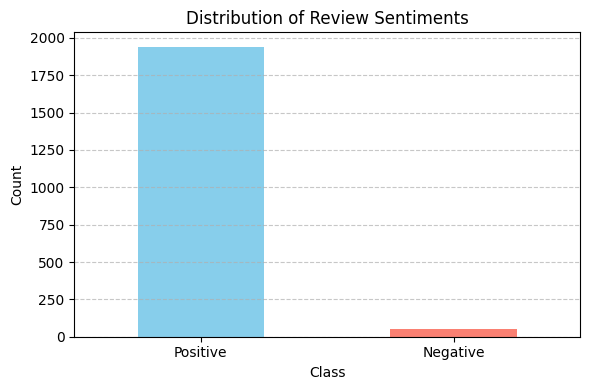

In [ ]:


# Count the class values
class_counts = Abjad_reviews['class'].value_counts()

# Plotting
plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['skyblue', 'salmon'])
print(class_counts)
plt.title('Distribution of Review Sentiments')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:


# Step 1: Combine all reviews into one text
all_text = ' '.join(Abjad_reviews['review'].dropna().astype(str))

# Step 2: Normalize and tokenize (remove punctuation, lowercase, split)
# You can adjust regex for more accurate Arabic tokenization if needed
words = re.findall(r'\b\w+\b', all_text)

# Step 3: Count word frequencies
word_counts = Counter(words)

# Step 4: Convert to DataFrame
word_freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'count'])

# Step 5: Get top 100 repeated words
top_100_words = word_freq_df.sort_values(by='count', ascending=False).head(100).reset_index(drop=True)

# Preview
print(top_100_words)

    word  count
0     من   4458
1     في   4190
2      و   2616
3    على   2058
4     أن   1836
..   ...    ...
95  بشكل    166
96  واحد    164
97   هنا    164
98  رحلة    162
99  جميع    160

[100 rows x 2 columns]


In [ ]:
def column_to_wordcloud(df, column, font_file, stopwords):

    text = " ".join(arabic_reshaper.reshape(t) for t in df[column].dropna())
    # create and display the wordcloud
    wordcloud = WordCloud(font_path=font_file, width = 3500, height = 2000, random_state=1, background_color='white', colormap='Set2', collocations=False,
                      stopwords = stopwords).generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()



In [ ]:
stopwords = pd.read_csv("/content/arabic_dialects_stopwords.csv")["word"].tolist()
stopwords = [arabic_reshaper.reshape(s) for s in stopwords]
print(len(stopwords))

1997


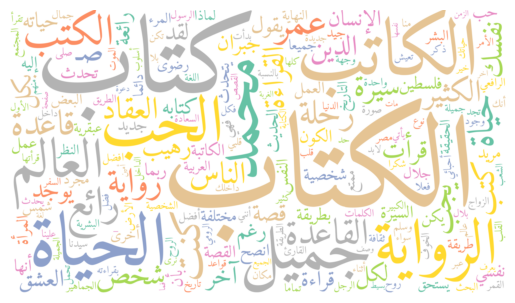

In [ ]:
column_to_wordcloud(Abjad_reviews,"review","/content/Amiri-Regular.ttf",stopwords)